In [1]:
from closeness_library import closeness_function
from degree_library import degree_function
from edge_clustering_library import edge_clustering_function
from diameter_library import diameter_function
from pathlib import Path
from ipyleaflet import Map, LayersControl, LayerGroup, Polygon, GeoJSON, LegendControl, FullScreenControl, basemaps, basemap_to_tiles
from ipywidgets.embed import embed_minimal_html
import json
import random
from tqdm.auto import tqdm
import pandas as pd
from itertools import chain
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap, Normalize
#from shapely.geometry import Point, LineString
from geojson import Feature, LineString
import numpy as np
import geopandas as gpd
from geojson_length import calculate_distance, Unit
from shapely.geometry import Point as geoPoint, Polygon as geoPolygon
from shapely import wkt
import geojson
from pyproj import Geod
from area import area
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
result_file = gpd.read_file(r'C:\\Users\\camperom\\safety-of-bike-networks\\Code\\OSM_extract\\GovermentData\\velo_mobilites_m.geojson')

In [3]:
names = list(set(result_file['type']))

In [4]:
df = pd.read_csv('tags_metrovelo.csv', header=None, index_col=0, sep=';').squeeze('columns')
mapping = df.to_dict()
# names

In [5]:
with open("./velo_mobilites_m.geojson", "r") as f:
    res = json.load(f)

In [6]:
features = {}

for feature in tqdm(res["features"]):
    try:
        tag = feature["properties"]["type"]
        if tag not in features.keys():
            features[tag] = []
        features[tag].append(feature)
    except:
        pass

  0%|          | 0/1295 [00:00<?, ?it/s]

In [7]:
result_file = 'C:\\Users\\camperom\\Documents\\Phd_Inria\\DataBaseFrance\\Administrative_limites_villes\\a_epci2021.json'

# Read the file with the administrative coordinates
with open(result_file, 'r', encoding='UTF-8') as f:
    gj = geojson.load(f)

# Find the index list of coordinates of the specific city
for i in range(len(list(gj["features"]))):
    if gj["features"][i]["properties"]["libgeo"] == "Grenoble-Alpes-Métropole":
        ind = i
        codgeo = gj["features"][i]["properties"]["codgeo"]
        break

#Create a Polygon shape 
coords = gj["features"][ind]["geometry"]["coordinates"]
poly = geoPolygon(coords[0])

In [8]:
def clean(feature):
    feature["properties"] = {p:v for p,v in feature["properties"].items() if v is not None}
    if 'way' in feature['properties'].keys():
        del feature['properties']['way']
    return feature

# max_lat = 45.229575
# min_lat = 45.132071
# max_lon = 5.798811
# min_lon = 5.664487
# bbox = [(min_lon, 45.132071),(5.798811, 45.229575)]
name_dict = dict([
    ('veloconseille', '3'), 
    ('chronovelo','1'), 
    ('veloseparatif','2'), 
    ('velodifficile',"4")
])
filt_features = {}
for key, feature_list in tqdm(features.items()):

    filt_features[name_dict[key]] = []
    for feature in feature_list:
        coord = feature['geometry']['coordinates']
        for c in coord:
            if type(c[0]) == float:
                lon = c[0]
                lat = c[1]
                pt = geoPoint(lon, lat)
                # if (poly.intersects(pt) == True) or (poly.contains(pt) == True):
                # if lon <= max_lon and lon >= min_lon and lat >= min_lat and lat <= max_lat:
                filt_features[name_dict[key]].append(clean(feature))
                break
            else:
                for cc in c:
                    lon = cc[0]
                    lat = cc[1]
                    pt = geoPoint(lon, lat)
                    # if (poly.intersects(pt) == True) or (poly.contains(pt) == True):
                    # if lon <= max_lon and lon >= min_lon and lat >= min_lat and lat <= max_lat:
                    filt_features[name_dict[key]].append(clean(feature))
                    break

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:

# Your dictionary structure
data = filt_features

# Create an empty graph
G = nx.Graph()

# Function to calculate geographic distance between two points

# Iterate through each key (e.g., '1', '2', '3', '4', etc.) in the dictionary
final_points = []
for key, features in data.items():
    for feature in features:
        geometry = feature['geometry']
        coordinates = geometry['coordinates']
        print(coordinates)
        if type(coordinates[0][0]) == float:
            for i in range(len(coordinates) - 1):
                endpoint1 = coordinates[i]
                endpoint2 = coordinates[i + 1]
                # print(endpoint1, endpoint2)
                line = Feature(geometry=LineString([endpoint1, endpoint2]))
                weight = int(key) #* calculate_distance(line, Unit.meters)
                print(weight, endpoint1, endpoint2)
                G.add_edge(tuple(endpoint1), tuple(endpoint2), weight=weight, key=int(key))
            final_points.append(tuple(coordinates[0]))
        else: 
            for sub_list in coordinates:
                for i in range(len(sub_list) - 1):
                    endpoint1 = sub_list[i]
                    endpoint2 = sub_list[i + 1]
                    # print(endpoint1, endpoint2)
                    line = Feature(geometry=LineString([endpoint1, endpoint2]))
                    weight = int(key)# * calculate_distance(line, Unit.meters)
                    print(weight, endpoint1, endpoint2)
                    G.add_edge(tuple(endpoint1), tuple(endpoint2), weight=weight, key=int(key))
                final_points.append(tuple(sub_list[0]))
        # weight = int(key) * calculate_distance(line, Unit.meters)
        # Convert the coordinates to a list of tuples
        # coordinates = [tuple(coord) for coord in coordinates]
        # print(coordinates)
        # Create a LineString from the coordinates
        # line = geoLineString(coordinates)

        # Calculate the weight as the key multiplied by the geographic distance
        

        # Add the edge to the graph with the weight
        


# Example: Getting the weight of an edge
# edge_weight = G.get_edge_data((5.74223, 45.17402), (5.7402, 45.17351))['weight']
# print(f"Edge weight: {edge_weight}")


[[5.74223, 45.17402], [5.74132, 45.1738], [5.74064, 45.17361], [5.7402, 45.17351]]
1 [5.74223, 45.17402] [5.74132, 45.1738]
1 [5.74132, 45.1738] [5.74064, 45.17361]
1 [5.74064, 45.17361] [5.7402, 45.17351]
[[5.73701, 45.17272], [5.7361, 45.17272], [5.73488, 45.17273]]
1 [5.73701, 45.17272] [5.7361, 45.17272]
1 [5.7361, 45.17272] [5.73488, 45.17273]
[[5.73488, 45.17273], [5.73483, 45.17273], [5.73481, 45.17295], [5.73482, 45.1731], [5.73476, 45.17315]]
1 [5.73488, 45.17273] [5.73483, 45.17273]
1 [5.73483, 45.17273] [5.73481, 45.17295]
1 [5.73481, 45.17295] [5.73482, 45.1731]
1 [5.73482, 45.1731] [5.73476, 45.17315]
[[5.73476, 45.17315], [5.73452, 45.17322], [5.73434, 45.17323], [5.73422, 45.17321], [5.73396, 45.17314], [5.73382, 45.17314]]
1 [5.73476, 45.17315] [5.73452, 45.17322]
1 [5.73452, 45.17322] [5.73434, 45.17323]
1 [5.73434, 45.17323] [5.73422, 45.17321]
1 [5.73422, 45.17321] [5.73396, 45.17314]
1 [5.73396, 45.17314] [5.73382, 45.17314]
[[5.75957, 45.20183], [5.76048, 45.20253]

In [10]:
print(len(list(G.nodes())), len(list(G.edges())), len(final_points))

12296 12919 1762


In [11]:
# junction_test = True
# while junction_test:
#     junction_test = False
for node in list(G.nodes()):
    if node not in final_points:
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 2:
            endpoint1 = neighbors[0]
            endpoint2 = neighbors[1]
            data1 = G.get_edge_data(node, endpoint1)
            data2 = G.get_edge_data(node, endpoint2)
            if data1['key'] == data2['key']:
                new_weight = data1['weight'] #+ data2['weight']
                new_key = data1['key']
                G.add_edge(endpoint1, endpoint2, weight=new_weight, key=new_key)
                G.remove_node(node)
                # junction_test = True

In [12]:
print(len(list(G.nodes())), len(list(G.edges())))

1880 2495


In [13]:
# Remove self-loops
def remove_self_loops(G):
    edges_to_remove = []
    for edge in G.edges():
        if edge[0] == edge[1]:
            edges_to_remove.append(edge)
    G.remove_edges_from(edges_to_remove)

In [14]:
print(len(list(G.nodes())), len(list(G.edges())))

1880 2495


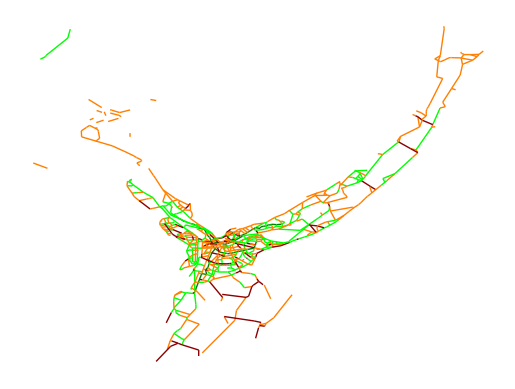

In [15]:
# Remove self-loops
# def remove_self_loops(G):
#     edges_to_remove = []
#     for edge in G.edges():
#         if edge[0] == edge[1]:
#             edges_to_remove.append(edge)
#     G.remove_edges_from(edges_to_remove)

remove_self_loops(G)

# Define colors for each key
colors = {4: '#8B0000', 3: '#FF8000', 2: '#00FF00', 1: '#008000'}

# Get the positions of the nodes (using the node coordinates as positions)
pos = {node: node for node in G.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=0)

# Iterate through the edges and draw them with the appropriate color
for edge in G.edges(data=True):
    endpoint1, endpoint2, data = edge
    key = data['key']
    color = colors[key]
    nx.draw_networkx_edges(G, pos, edgelist=[(endpoint1, endpoint2)], edge_color=color, width=1)

# Show the plot
plt.axis('off')
plt.show()

1
2
3
4


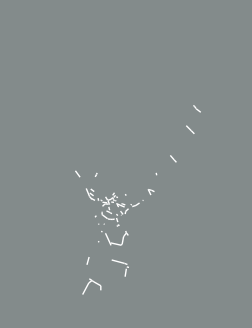

In [16]:
# colors = {4: '#8B0000', 3: '#FF8000', 2: '#00FF00', 1: '#008000'}
colors = {4: '#FFFFFF', 3: '#FFFFFF', 2: '#FFFFFF', 1: '#FFFFFF'}
# Get the positions of the nodes (using the node coordinates as positions)
pos = {node: node for node in G.nodes()}

# Draw the nodes
fig, ax = plt.subplots(figsize=(3, 4))
nx.draw_networkx_nodes(G, pos, node_size=0)
n=4
# Iterate through the edges and draw them with the appropriate color
for i in range(1, 5):
    print(i)
    if i == n:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == i], edge_color=colors[i], width=1)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == i], edge_color="#FFFFFF", width=0)


# Show the plot
fig.set_facecolor('#838B8B')
plt.axis('off')
plt.savefig(f"Grenoble_description_level_{n+1}.png", dpi=800, bbox_inches='tight')
plt.show()

In [17]:
# Create a graph

# Compute the betweenness centrality of the edges
# edge_betweenness = nx.edge_betweenness_centrality(G)
bca = nx.edge_betweenness_centrality(G, k=None, normalized=True, weight='weight', seed=None)
edge_betweenness = {}
s_bca = sum(list(bca.values()))
for i in list(bca.keys()):
    edge_betweenness[i] = (bca[i]/s_bca)*100

# Get the minimum and maximum betweenness centrality values
min_betweenness = min(edge_betweenness.values())
max_betweenness = max(edge_betweenness.values())

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality
# pos = nx.spring_layout(G)


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3716474654.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3729166135.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))
C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3729166135.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(norm=None, cmap=edge_color_map), shrink=0.7)


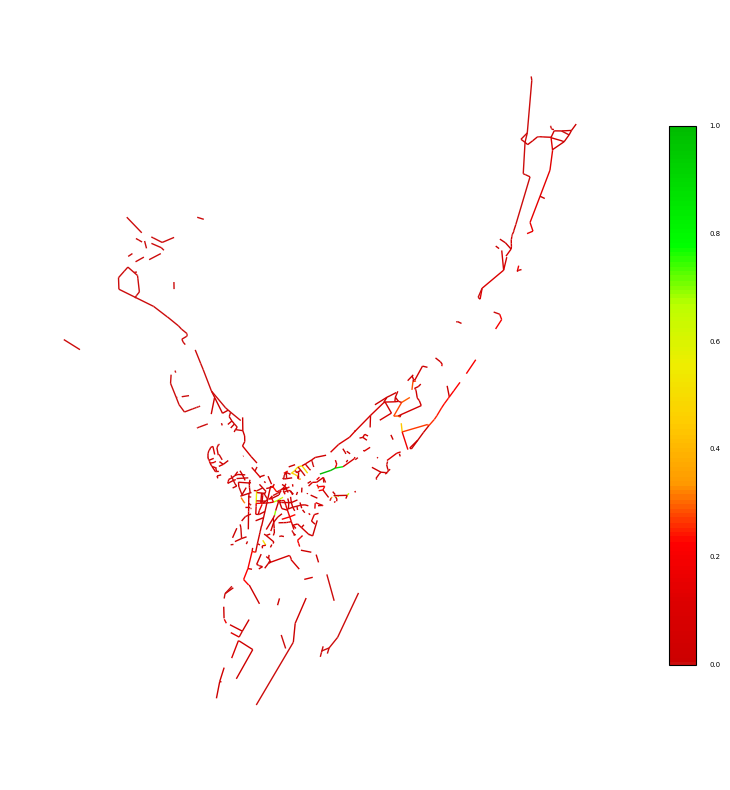

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=0)
n = 3
n_edges = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] == n]
n_edge_betweenness = [edge_betweenness[(u, v)] for u, v in n_edges]
min_betweenness = min(n_edge_betweenness)
max_betweenness = max(n_edge_betweenness)

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0)

for i in range(1, 5):
    if i == n:
        # Draw the edges with colors based on their betweenness centrality
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == i], edge_color=[edge_color_map((edge_betweenness[(u, v)] - min_betweenness) / (max_betweenness - min_betweenness)) for u, v, data in G.edges(data=True) if data['weight'] == i], width=[1 if edge_betweenness[(u, v)] >= 0.1 else 1 for u, v, data in G.edges(data=True) if data['weight'] == i], edge_cmap=edge_color_map, edge_vmin=min_betweenness, edge_vmax=max_betweenness)
    else:
        # Draw the edges with white color
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == i], edge_color="#FFFFFF", width=0)

# Add a colorbar for the edge colors
# plt.colorbar(cm.ScalarMappable(norm=None, cmap=edge_color_map))
cbar = plt.colorbar(cm.ScalarMappable(norm=None, cmap=edge_color_map), shrink=0.7)
cbar.ax.tick_params(labelsize=5, which='both', length=0, pad=10, labelcolor='black')
# Show the plot
plt.axis('off')
plt.savefig(f"Betweenness_grenoble.png", dpi=800, bbox_inches='tight')
plt.show()


In [19]:
for i in reversed(list(dict(sorted(edge_betweenness.items(), key=lambda item: item[1])))):
    print(i, edge_betweenness[i])

((5.75251, 45.19603), (5.7539, 45.19696)) 0.8313590181473238
((5.7351, 45.18636), (5.73217, 45.1852)) 0.8120225325300924
((5.75251, 45.19603), (5.74359, 45.19034)) 0.7905292659663129
((5.74359, 45.19034), (5.74046, 45.18858)) 0.7900873195004601
((5.73732, 45.1872), (5.74046, 45.18858)) 0.7894993220566214
((5.73732, 45.1872), (5.7351, 45.18636)) 0.7892887810364084
((5.76916, 45.19899), (5.7539, 45.19696)) 0.7651579756160511
((5.76916, 45.19899), (5.77083, 45.20045)) 0.5434588503613805
((5.77083, 45.20045), (5.78208, 45.203)) 0.5256595987066034
((5.78208, 45.203), (5.78667, 45.20463)) 0.5234271051859648
((5.77042, 45.19826), (5.76916, 45.19899)) 0.5224436952675273
((5.71675, 45.17379), (5.71559, 45.17039)) 0.48902410184058454
((5.71262, 45.16343), (5.71559, 45.17039)) 0.4868535693409094
((5.71262, 45.16343), (5.7138, 45.15978)) 0.4846855658624982
((5.77042, 45.19826), (5.77983, 45.19237)) 0.48055336640677476
((5.7138, 45.15978), (5.71345, 45.15896)) 0.480390023245897
((5.71219, 45.15436)

In [20]:
# length_networks = {}
# for name in list(filt_features.keys()):
#     s = 0
#     for dictionary in filt_features[name]:
#         if type(dictionary["geometry"]['coordinates'][0][0]) == float:
#             print(dictionary["geometry"]["coordinates"])
#             line = Feature(geometry=LineString(dictionary["geometry"]['coordinates']))
#             s = s + calculate_distance(line, Unit.meters)
#         else: 
#             for sub_list in dictionary["geometry"]['coordinates']:
#                 line = Feature(geometry=LineString(sub_list))
#                 s = s + calculate_distance(line, Unit.meters)
#                 print(sub_list)
#     length_networks[name] = s/1000
#         # print(dictionary)
#         # print(dictionary["geometry"]['coordinates'])
#         # print(line)
#         # calculate_distance(line, Unit.meters)

In [21]:
# total = sum(list(length_networks.values()))
# # ml_hab = total*1000/population
# # ml_km2 = total*1000/sq_area
# percentaje_networks = {}
# for key in list(length_networks.keys()):
#     percentaje_networks[key] = length_networks[key]*100/total

# def round_2(var):
#     return round(var, 2)

# substitute_lambda = lambda s: s.replace('_', '$_{-}$')

# for i, key in enumerate(sorted(length_networks.keys())):
#     for o_key in list(name_dict.keys()):
#         if name_dict[o_key] == key:
#             print(substitute_lambda(key), "&", substitute_lambda(o_key), '&', round_2(length_networks[key]), "&", round_2(percentaje_networks[key]), r"\\")
# print(r"\hline")            
# print('Total', "&", '&', round_2(total), "&", '100', r"\\")
# print(r"\hline")

In [22]:

# def to_geojson(features):
#     geojson = {'type':'FeatureCollection', 'features':[]}
#     geojson['features'] = features
#     return geojson

# center = poly.centroid.coords[0][::-1] 
# # m = Map(basemap=basemaps.HikeBike.HikeBike, center=center) #Black
# # m = Map(basemap=basemaps.CartoDB.DarkMatter, center=center) #Dark
# m = Map(basemap=basemaps.CartoDB.Positron, center=center) #Current color in the paper
# # m = Map(basemap=basemaps.Esri.WorldTopoMap, center=center)
# # m = Map(basemap=basemaps.CartoDB.Positron, center=center)
# # m = Map(basemap=basemaps.Esri.WorldImagery, center=center)     
# b = poly.bounds
# bounds = [[b[1], b[0]], [b[3], b[2]]]
# m.fit_bounds(bounds)
# m.add_layer(LayerGroup(layers=[Polygon(locations=[c[::-1] for c in coords[0]], fill=False)], name="EPCI"))
# legend = LegendControl(legend={},name="Legend", position="bottomleft")
# m.add_control(legend)

# n = len(filt_features.keys())
# colormap = cm.get_cmap('nipy_spectral', 256) 
# aux_array = np.linspace(0.5, 0.9, n)
# # aux_array[5] = 0.0
# color_vector = ListedColormap(colormap(aux_array))
# # color_vector = ["#66CD00", "#FFFF00", "#EE5C42", "#FF0000", "#CD0000", "#000000"]
# roadPalette = {}

# # colormap = cm.get_cmap('gist_ncar', 256) 
# # color_vector = ListedColormap(colormap(np.linspace(0, 1, n)))
# # roadPalette = {}
# name_vector = ["1", "2", "3", "4"]
# for i in range(n):
#     # roadPalette[sorted(list(filt_features.keys()))[i]] = color_vector.colors[i]
#     roadPalette[sorted(name_vector)[i]] = color_vector.colors[i]


# aux_vector = []
# aux_vector_1 = []
# # run through all lines
# for key, feature_list in tqdm(sorted(list(filt_features.items()))):
    
#     # create random hexadecimal color
#     #r = lambda: random.randint(0,255) 
#     #color = '#%02X%02X%02X' % (r(),r(),r())

#     def rgb_to_hex(palette):
#         palette = [int(255*x) for x in palette]
#         return '#{:02x}{:02x}{:02x}'. format(*palette)
#     color = rgb_to_hex(roadPalette[key])
#     aux_vector_1.append((key, color))

#     # legend.add_legend_element(key, color)

#     # create a new GeoJSON feature in leaflet and add it to a new layer
#     layer_group = LayerGroup(layers=[
#         GeoJSON(data=geo_line, style={'color': color, 'weight': 4}) for geo_line in feature_list
#     ] , name=key)
#     aux_vector.append(layer_group)
#     # print(layer_group)
# aux_vector.reverse()
# # aux_vector_1.reverse()
# for i in aux_vector:
#     m.add_layer(i)

# for i in aux_vector_1:
#     legend.add_legend_element(i[0],i[1])

# # add layer control
# control = LayersControl(position='topleft')
# m.add_control(control)
# m.add_control(FullScreenControl())
# # show the map
# # Create a headless Chrome browser
# # m
# # Get the JSON representation of the map
# embed_minimal_html('./Grenoble_metropole_proposal.html', views=[m])
# # embed_minimal_html('./Grenoble_metropole_categories_proposal.html', views=[m])
# #embed_minimal_html('./map_goverment_1.html', views=[m])

In [23]:
# colors = {4: '#8B0000', 3: '#FF8000', 2: '#00FF00', 1: '#008000'}

# # Get the positions of the nodes (using the node coordinates as positions)
# pos = {node: node for node in G.nodes()}

# # Draw the nodes
# nx.draw_networkx_nodes(G, pos, node_size=0)
# n=1
# # Iterate through the edges and draw them with the appropriate color
# for i in range(1, 5):
#     if i == n:
#         nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == colors[i-1]], edge_color=color, width=1)
#     else:
#         nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, data in G.edges(data=True) if data['weight'] == "#FFFFFF"], edge_color=color, width=1)


# # Show the plot
# plt.axis('off')
# plt.show()

In [24]:
def compute_norms(values):
    # Convert the list of vectors to a numpy array
    values_array = np.array(values)

    # Compute the difference between each vector and the first vector
    diff = values_array - values_array[0]

    # Compute the norm of each row in the difference array
    norms = np.linalg.norm(diff, axis=1)

    return norms

# print(compute_norms(vector_functions))

strength = [57.48899051490509, 59.513042005420004, 60.86805555555551, 61.9063346883469, 62.95435298102983, 64.65658875338752, 65.78717818428181, 66.7941226287263, 67.909891598916, 68.98416327913283, 70.13169037940384, 71.29827235772362, 72.45638550135506, 73.58231707317074, 74.6726795392954, 75.82655826558263, 77.04818766937662, 78.2507621951219, 79.46815718157178, 80.69910230352299, 81.72467818428186]
closennes = [41.51450533162684, 42.13318987108123, 42.48578953229026, 42.61209227202198, 42.643257076077745, 42.673771152952924, 42.72264981487195, 42.79749863682726, 42.8631612314369, 42.991496645234896, 43.11484816631971, 43.26178283870101, 43.47970267993209, 43.78880774860035, 44.174585155087364, 44.564600265450046, 45.15096749849634, 45.75094134869607, 46.48917491800907, 47.60510915117394, 49.66736586675631]
diameter = [35.39267015706806, 35.39267015706806, 35.44502617801047, 36.07329842931937, 36.596858638743456, 37.382198952879584, 38.952879581151834, 39.94764397905759, 40.99476439790576, 41.78010471204188, 41.93717277486911, 42.40837696335078, 52.82722513089006, 55.287958115183244, 56.282722513089, 63.769633507853406, 64.60732984293193, 65.81151832460733, 70.10471204188482, 70.94240837696336, 88.27225130890054]
edge_clustering = [5.2631578947368425, 7.017543859649122, 7.017543859649122, 7.017543859649122, 12.280701754385966, 17.54385964912281, 22.80701754385965, 29.82456140350877, 42.10526315789474, 50.87719298245614, 50.87719298245614, 59.64912280701754, 63.1578947368421, 63.1578947368421, 66.66666666666667, 66.66666666666667, 66.66666666666667, 70.17543859649123, 70.17543859649123, 70.17543859649123, 71.9298245614035]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closennes[i], diameter[i], edge_clustering[i]])
vec_aux = compute_norms(vec_aux)
vec_aux = [i-vec_aux[0] for i in vec_aux]

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Create a graph
# G = nx.karate_club_graph()

# Compute the betweenness centrality of the edges with weight == 2
bca= {edge: centrality for edge, centrality in nx.edge_betweenness_centrality(G).items() if G.edges[edge]['weight'] == 3}

edge_betweenness = {}
s_bca = max(list(bca.values()))
for i in list(bca.keys()):
    edge_betweenness[i] = (bca[i]/s_bca)

# Sort the edges by their betweenness centrality in descending order
sorted_edges = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)

# Divide the edges into sets of approximately equal size
num_edges = len(sorted_edges)
num_sets = 20
set_size = num_edges // num_sets
edge_sets = [sorted_edges[i:i+set_size] for i in range(0, num_edges, set_size)]

# Compute the average betweenness centrality of each set
set_centralities = [sum(edge_betweenness[edge] for edge in edge_set) / len(edge_set) for edge_set in edge_sets]
maxcentrialities = max(set_centralities)
mincentralities = min(set_centralities)
set_centralities = [(edge_set-mincentralities)/(maxcentrialities-mincentralities) for edge_set in set_centralities ]

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3768060235.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


958
958
1.0 0.0
0 47
47
47
1.0
1 47
47
47
0.5898479729313603
2 47
47
47
0.3643639275410127
3 47
47
47
0.2889858721403868
4 47
47
47
0.2347198640859552
5 47
47
47
0.1916030762835438
6 47
47
47
0.14975531667373967
7 47
47
47
0.12032277394580276
8 47
47
47
0.10058493474789243
9 47
47
47
0.08081228092820733
10 47
47
47
0.06074465745794133
11 47
47
47
0.04293323352026182
12 47
47
47
0.03189203395759814
13 47
47
47
0.023185447583538705
14 47
47
47
0.016533296080903717
15 47
47
47
0.01128051619779187
16 47
47
47
0.01128051619779187
17 47
47
47
0.006260424570620216
18 47
47
47
0.00020422503163677213
19 47
47
47
6.02968768394693e-06
20 18
18
18
0.0


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\4027848161.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.7)


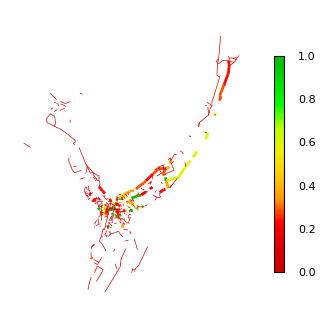

In [26]:
print(len(sorted_edges))
s = 0
for i in edge_sets:
    s = s + len(i)
print(s)
s1 = 0
# print(len(set_centralities))
# for i in set_centralities:
#     s1 = s1 + len(i)
# print(s1)
fig, ax = plt.subplots(figsize=(4, 4))
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0)
print(max(set_centralities), min(set_centralities))
for i, edge_set in enumerate(edge_sets):
    # Draw the edges in the first set with colors based on their betweenness centrality
    print(i, len(edge_set))
    print(len([edge_color_map((edge_betweenness[edge] - min(edge_betweenness.values())) / (max(edge_betweenness.values()) - min(edge_betweenness.values()))) for edge in edge_set]))
    edge_color_v = [set_centralities[i] for j in range(len(edge_set))]
    print(len(edge_color_v)) 
    print(set_centralities[i])
    nx.draw_networkx_edges(G, pos, edgelist=edge_set, edge_color=edge_color_v, width=[2 if set_centralities[i] >= sum(set_centralities)/len(set_centralities) else 0.5 for j in range(len(edge_set))], edge_cmap=edge_color_map, edge_vmin=min(set_centralities), edge_vmax=max(set_centralities))
#np.full(np.arange(len(edge_set)), set_centralities[i])

# Add a colorbar for the edge colors
sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)))
cbar = plt.colorbar(sm, shrink=0.7)
cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=8)
# sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)), )
# sm.set_array([])
# cbar = plt.colorbar(sm, shrink=0.5)
# cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=12)
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.ax.yaxis.set_label_position('left')
# cbar.ax.set_ylabel('Betweenness Centrality', rotation=270, fontsize=14, labelpad=20)
# cbar.ax.yaxis.set_tick_params(width=0)
# Show the plot
plt.axis('off')
plt.savefig(f"Betweenness_grenoble.png", dpi=800, bbox_inches='tight')
plt.show()

In [27]:
print(len(set_centralities))
print(len(vec_aux))

21
21


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\2342102342.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


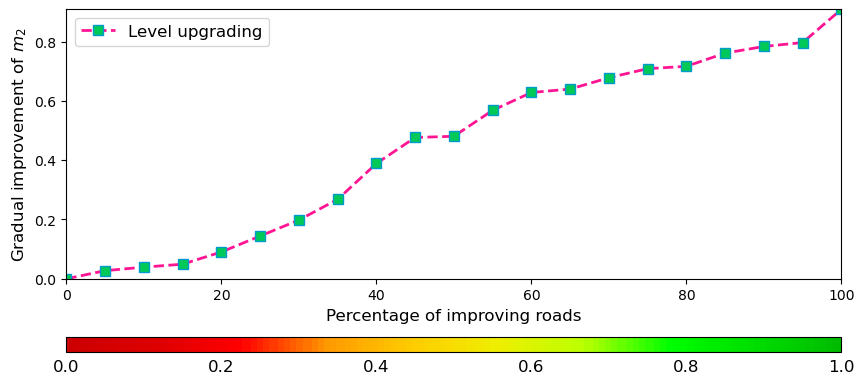

In [28]:
# Define the data
strength = [57.48899051490509, 59.513042005420004, 60.86805555555551, 61.9063346883469, 62.95435298102983, 64.65658875338752, 65.78717818428181, 66.7941226287263, 67.909891598916, 68.98416327913283, 70.13169037940384, 71.29827235772362, 72.45638550135506, 73.58231707317074, 74.6726795392954, 75.82655826558263, 77.04818766937662, 78.2507621951219, 79.46815718157178, 80.69910230352299, 81.72467818428186]
closeness = [41.51450533162684, 42.13318987108123, 42.48578953229026, 42.61209227202198, 42.643257076077745, 42.673771152952924, 42.72264981487195, 42.79749863682726, 42.8631612314369, 42.991496645234896, 43.11484816631971, 43.26178283870101, 43.47970267993209, 43.78880774860035, 44.174585155087364, 44.564600265450046, 45.15096749849634, 45.75094134869607, 46.48917491800907, 47.60510915117394, 49.66736586675631]
# diameter = [35.39267015706806, 35.39267015706806, 35.44502617801047, 36.07329842931937, 36.596858638743456, 37.382198952879584, 38.952879581151834, 39.94764397905759, 40.99476439790576, 41.78010471204188, 41.93717277486911, 42.40837696335078, 52.82722513089006, 55.287958115183244, 56.282722513089, 63.769633507853406, 64.60732984293193, 65.81151832460733, 70.10471204188482, 70.94240837696336, 88.27225130890054]
diameter = [30.00554631170272, 30.00554631170272, 30.061009428729896, 30.72656683305602, 31.281198003327788, 32.11314475873544, 33.777038269550744, 35.108153078202996, 36.605657237936775, 37.437603993344425, 38.10316139767055, 38.60232945091514, 49.14032168607876, 51.80255130338325, 52.85635052689961, 60.06655574043261, 61.064891846921796, 63.56073211314476, 67.60953965612867, 69.43982251802552, 86.18968386023295]
edge_clustering = [5.2631578947368425, 7.017543859649122, 7.017543859649122, 7.017543859649122, 12.280701754385966, 17.54385964912281, 22.80701754385965, 29.82456140350877, 42.10526315789474, 50.87719298245614, 50.87719298245614, 59.64912280701754, 63.1578947368421, 63.1578947368421, 66.66666666666667, 66.66666666666667, 66.66666666666667, 70.17543859649123, 70.17543859649123, 70.17543859649123, 71.9298245614035]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closeness[i], diameter[i], edge_clustering[i]])
vec_aux = compute_norms(vec_aux)
vec_aux = [(i-vec_aux[0])/100 for i in vec_aux]
x1 = np.linspace(0, 100, 21)

# Define the colormap
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
# for i in range(4):
#     ax.plot(x1, vec_aux[:, i], color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label=["Strength", "Closeness", "Diameter", "Edge Clustering"][i], markersize=7)
plt.plot(x1, vec_aux, color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label="Level upgrading", markersize=7)
# Set the x and y limits
ax.set_xlim([min(x1), max(x1)])
ax.set_ylim([min(vec_aux), max(vec_aux)])

# Add a horizontal colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities))), ax=ax, orientation='horizontal', aspect=50)
cbar.ax.tick_params(which='both', length=0, pad=5, labelcolor='black', labelsize=12)

# Set the x and y labels
ax.set_xlabel("Percentage of improving roads", fontsize=12)
ax.set_ylabel(r'Gradual improvement of $m_{2}$', fontsize=12)

# Set the legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.savefig('./Images/second_scenario_1.png', dpi=800)
plt.show()

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3910004945.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


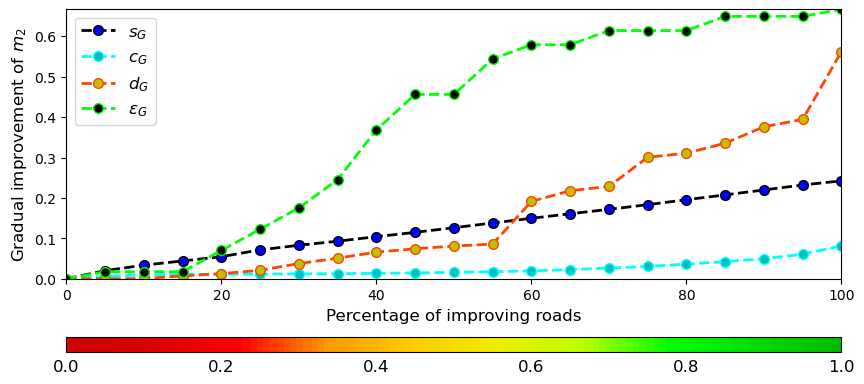

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize

# Define the data
strength = [57.48899051490509, 59.513042005420004, 60.86805555555551, 61.9063346883469, 62.95435298102983, 64.65658875338752, 65.78717818428181, 66.7941226287263, 67.909891598916, 68.98416327913283, 70.13169037940384, 71.29827235772362, 72.45638550135506, 73.58231707317074, 74.6726795392954, 75.82655826558263, 77.04818766937662, 78.2507621951219, 79.46815718157178, 80.69910230352299, 81.72467818428186]
closeness = [41.51450533162684, 42.13318987108123, 42.48578953229026, 42.61209227202198, 42.643257076077745, 42.673771152952924, 42.72264981487195, 42.79749863682726, 42.8631612314369, 42.991496645234896, 43.11484816631971, 43.26178283870101, 43.47970267993209, 43.78880774860035, 44.174585155087364, 44.564600265450046, 45.15096749849634, 45.75094134869607, 46.48917491800907, 47.60510915117394, 49.66736586675631]
# diameter = [35.39267015706806, 35.39267015706806, 35.44502617801047, 36.07329842931937, 36.596858638743456, 37.382198952879584, 38.952879581151834, 39.94764397905759, 40.99476439790576, 41.78010471204188, 41.93717277486911, 42.40837696335078, 52.82722513089006, 55.287958115183244, 56.282722513089, 63.769633507853406, 64.60732984293193, 65.81151832460733, 70.10471204188482, 70.94240837696336, 88.27225130890054]
diameter = [30.00554631170272, 30.00554631170272, 30.061009428729896, 30.72656683305602, 31.281198003327788, 32.11314475873544, 33.777038269550744, 35.108153078202996, 36.605657237936775, 37.437603993344425, 38.10316139767055, 38.60232945091514, 49.14032168607876, 51.80255130338325, 52.85635052689961, 60.06655574043261, 61.064891846921796, 63.56073211314476, 67.60953965612867, 69.43982251802552, 86.18968386023295]
edge_clustering = [5.2631578947368425, 7.017543859649122, 7.017543859649122, 7.017543859649122, 12.280701754385966, 17.54385964912281, 22.80701754385965, 29.82456140350877, 42.10526315789474, 50.87719298245614, 50.87719298245614, 59.64912280701754, 63.1578947368421, 63.1578947368421, 66.66666666666667, 66.66666666666667, 66.66666666666667, 70.17543859649123, 70.17543859649123, 70.17543859649123, 71.9298245614035]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closeness[i], diameter[i], edge_clustering[i]])
vec_aux = np.array(vec_aux)/100
# vec_aux = vec_aux / np.linalg.norm(vec_aux, axis=0)
vec_aux = vec_aux - vec_aux[0]
x1 = np.linspace(0, 100, 21)

# Define the colormap
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
markers = ["," , "o" , "^" , "<"]
colors = ['#000000','#00FFFF', '#FF4500','#00FF00']
colors_edge = ['b','c', 'y', 'k']
labels = ['$s_{G}$ ','$c_{G}$','$d_{G}$','$ \\varepsilon_{G}$']
# differences = [diff_1, diff_2, diff_3, diff_4]
for i in range(4):
    plt.plot(x1, vec_aux[:, i],
                color=colors[i],
                markeredgecolor=colors[i],
                lw=2,
                ls='--',
                markerfacecolor=colors_edge[i],
                marker='o',
                #edgecolor=colors_edge[i],
                label=labels[i],
                markersize=7)
# for i in range(4):
#     ax.plot(x1, vec_aux[:, i], color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label=["Strength", "Closeness", "Diameter", "Edge Clustering"][i], markersize=7)

# Set the x and y limits
ax.set_xlim([min(x1), max(x1)])
# ax.set_ylim([min(edge_clustering), max(edge_clustering)])
ax.set_ylim([min(vec_aux.flatten()), max(vec_aux.flatten())])

# Add a horizontal colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities))), ax=ax, orientation='horizontal', aspect=50)
cbar.ax.tick_params(which='both', length=0, pad=5, labelcolor='black', labelsize=12)

# Set the x and y labels
ax.set_xlabel("Percentage of improving roads", fontsize=12)
ax.set_ylabel(r'Gradual improvement of $ m_{2}$', fontsize=12)

# Set the legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.savefig('./Images/second_scenario_2.png', dpi=800)
plt.show()

In [30]:
strength_var = np.var(strength)
closeness_var = np.var(closeness)
diameter_var = np.var(diameter)
edge_clustering_var = np.var(edge_clustering)

# Print the results
print(f"Variance of strength: {strength_var}")
print(f"Variance of closeness: {closeness_var}")
print(f"Variance of diameter: {diameter_var}")
print(f"Variance of edge clustering: {edge_clustering_var}")

Variance of strength: 50.59596895663708
Variance of closeness: 3.831174517573769
Variance of diameter: 257.64224052711626
Variance of edge clustering: 638.731331252107


In [31]:
bca= {edge: centrality for edge, centrality in nx.edge_betweenness_centrality(G).items() if G.edges[edge]['weight'] == 4}

edge_betweenness = {}
s_bca = max(list(bca.values()))
for i in list(bca.keys()):
    edge_betweenness[i] = (bca[i]/s_bca)

# Sort the edges by their betweenness centrality in descending order
sorted_edges = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)

# Divide the edges into sets of approximately equal size
num_edges = len(sorted_edges)
num_sets = 20
set_size = num_edges // num_sets
edge_sets = [sorted_edges[i:i+set_size] for i in range(0, num_edges, set_size)]

# Compute the average betweenness centrality of each set
set_centralities = [sum(edge_betweenness[edge] for edge in edge_set) / len(edge_set) for edge_set in edge_sets]
maxcentrialities = max(set_centralities)
mincentralities = min(set_centralities)
set_centralities = [(edge_set-mincentralities)/(maxcentrialities-mincentralities) for edge_set in set_centralities ]

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\4275119421.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


1.0 0.0


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\1726454596.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.7)


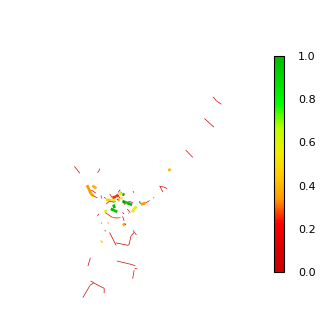

In [32]:

# print(len(set_centralities))
# for i in set_centralities:
#     s1 = s1 + len(i)
# print(s1)
fig, ax = plt.subplots(figsize=(4, 4))
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0)
print(max(set_centralities), min(set_centralities))
for i, edge_set in enumerate(edge_sets):
    # Draw the edges in the first set with colors based on their betweenness centrality
    # print(i, len(edge_set))
    # print(len([edge_color_map((edge_betweenness[edge] - min(edge_betweenness.values())) / (max(edge_betweenness.values()) - min(edge_betweenness.values()))) for edge in edge_set]))
    edge_color_v = [set_centralities[i] for j in range(len(edge_set))]
    # print(len(edge_color_v)) 
    # print(set_centralities[i])
    nx.draw_networkx_edges(G, pos, edgelist=edge_set, edge_color=edge_color_v, width=[2 if set_centralities[i] >= sum(set_centralities)/len(set_centralities) else 0.5 for j in range(len(edge_set))], edge_cmap=edge_color_map, edge_vmin=min(set_centralities), edge_vmax=max(set_centralities))
#np.full(np.arange(len(edge_set)), set_centralities[i])

# Add a colorbar for the edge colors
sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)))
cbar = plt.colorbar(sm, shrink=0.7)
cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=8)
# sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)), )
# sm.set_array([])
# cbar = plt.colorbar(sm, shrink=0.5)
# cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=12)
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.ax.yaxis.set_label_position('left')
# cbar.ax.set_ylabel('Betweenness Centrality', rotation=270, fontsize=14, labelpad=20)
# cbar.ax.yaxis.set_tick_params(width=0)
# Show the plot
plt.axis('off')
plt.savefig(f"Betweenness_grenoble_from_1_to_2.png", dpi=800, bbox_inches='tight')
plt.show()

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\2084940339.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


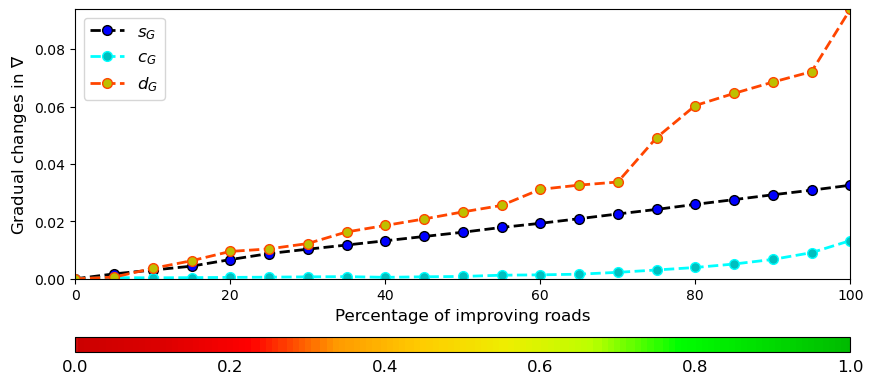

In [33]:
#FROM 1 TO 2
strength = [57.48899051490509, 57.66048441734412, 57.79386856368561, 57.92936991869916, 58.15908705962059, 58.36974932249322, 58.52112974254742, 58.66615853658536, 58.81436314363143, 58.96362635501356, 59.11225440379403, 59.279513888888886, 59.42284891598916, 59.58375677506775, 59.74889905149052, 59.90768970189703, 60.08341802168022, 60.24856029810298, 60.41730182926829, 60.578209688346895, 60.7497035907859]
edge_clustering = [71.9298245614035, 71.9298245614035, 85.96491228070175, 89.47368421052632, 89.47368421052632, 92.98245614035088, 92.98245614035088, 92.98245614035088, 92.98245614035088, 96.49122807017544, 96.49122807017544, 96.49122807017544, 96.49122807017544, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
# diameter = [86.18968386023295, 86.18968386023295, 86.46699944536883, 86.63338879645036, 87.24348308374931, 87.29894620077648, 87.35440931780366, 88.01996672212978, 88.18635607321131, 88.4636716583472, 88.6855241264559, 89.07376594564614, 89.9057127010538, 90.07210205213532, 90.12756516916251, 92.90072102052135, 95.00831946755409, 95.72933998890738, 96.3948973932335, 96.8940654464781, 100.0]
#diameter = [58.285509325681495, 58.3452893352463, 58.51267336202773, 58.68005738880918, 58.84744141559063, 59.014825442372064, 59.18220946915351, 59.34959349593496, 59.51697752271641, 59.684361549497844, 59.85174557627929, 60.01912960306074, 60.186513629842175, 60.35389765662362, 60.52128168340507, 60.68866571018652, 60.856049736967954, 61.0234337637494, 61.19081779053085, 61.358201817312285, 61.54949784791965]
diameter = [58.975115569981305, 59.034130028523656, 59.339038064325756, 59.604603127766296, 59.929182649749194, 60.017704337562705, 60.204583456280126, 60.60784892298613, 60.83407101406512, 61.06029310514409, 61.306186682403855, 61.532408773482835, 62.0930461296351, 62.24058227599095, 62.34877544998525, 63.892987115176545, 65.01426182748106, 65.43719878036785, 65.83062850398348, 66.19455099832793, 68.36825022130422]
closeness = [0.45047140896203053, 0.45088499694200085, 0.45082000186041504, 0.45088008875346847, 0.4509673018327711, 0.4510426042226104, 0.45115691742830144, 0.45123174907732844, 0.45098395559492793, 0.45117417982401503, 0.45129236358070024, 0.45172991227738807, 0.45185158024422, 0.45208470134695816, 0.45272744220003003, 0.4535460564809435, 0.45441343932963635, 0.4556244705976293, 0.4572263222453883, 0.45958491937010276, 0.463782294311847]
# closeness = [41.51450533162684, 41.55588709114724, 41.55849900803125, 41.56509710001414, 41.573490818861835, 41.580426941028, 41.5956201261148, 41.61345770277875, 41.63408961815237, 41.659631616474265, 41.69613239755049, 41.73775352547659, 41.793105772271524, 41.8594151295603, 41.93604926003764, 42.023553119682035, 42.1113811510486, 42.23465444396502, 42.39747889230064, 42.60354948594502, 42.97032036943511]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closeness[i]*100, diameter[i]])
vec_aux = np.array(vec_aux)/100
# vec_aux = vec_aux / np.linalg.norm(vec_aux, axis=0)
vec_aux = vec_aux - vec_aux[0]
x1 = np.linspace(0, 100, 21)

# Define the colormap
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
markers = ["," , "o" , "^" , "<"]
colors = ['#000000','#00FFFF', '#FF4500','#00FF00']
colors_edge = ['b','c', 'y', 'k']
labels = ['$s_{G}$ ','$c_{G}$','$d_{G}$','$ \\varepsilon_{G}$']
# differences = [diff_1, diff_2, diff_3, diff_4]
for i in range(3):
    plt.plot(x1, vec_aux[:, i],
                color=colors[i],
                markeredgecolor=colors[i],
                lw=2,
                ls='--',
                markerfacecolor=colors_edge[i],
                marker='o',
                #edgecolor=colors_edge[i],
                label=labels[i],
                markersize=7)
# for i in range(4):
#     ax.plot(x1, vec_aux[:, i], color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label=["Strength", "Closeness", "Diameter", "Edge Clustering"][i], markersize=7)

# Set the x and y limits
ax.set_xlim([min(x1), max(x1)])
# ax.set_ylim([min(edge_clustering), max(edge_clustering)])
ax.set_ylim([min(vec_aux.flatten()), max(vec_aux.flatten())])

# Add a horizontal colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities))), ax=ax, orientation='horizontal', aspect=50)
cbar.ax.tick_params(which='both', length=0, pad=5, labelcolor='black', labelsize=12)

# Set the x and y labels
ax.set_xlabel("Percentage of improving roads", fontsize=12)
ax.set_ylabel(r'Gradual changes in $\nabla$', fontsize=12)

# Set the legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.savefig('./Images/second_scenario_2_from_1_to_2.png', dpi=800)
plt.show()

In [34]:
bca= {edge: centrality for edge, centrality in nx.edge_betweenness_centrality(G).items() if G.edges[edge]['weight'] == 3}

edge_betweenness = {}
s_bca = max(list(bca.values()))
for i in list(bca.keys()):
    edge_betweenness[i] = (bca[i]/s_bca)

# Sort the edges by their betweenness centrality in descending order
sorted_edges = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)

# Divide the edges into sets of approximately equal size
num_edges = len(sorted_edges)
num_sets = 20
set_size = num_edges // num_sets
edge_sets = [sorted_edges[i:i+set_size] for i in range(0, num_edges, set_size)]

# Compute the average betweenness centrality of each set
set_centralities = [sum(edge_betweenness[edge] for edge in edge_set) / len(edge_set) for edge_set in edge_sets]
maxcentrialities = max(set_centralities)
mincentralities = min(set_centralities)
set_centralities = [(edge_set-mincentralities)/(maxcentrialities-mincentralities) for edge_set in set_centralities ]

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3397482558.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


1.0 0.0


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\288682921.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.7)


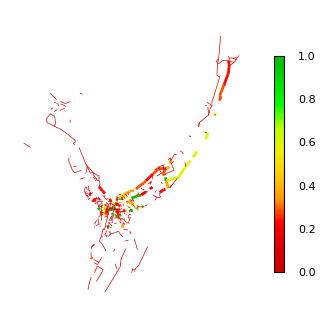

In [35]:
# print(len(set_centralities))
# for i in set_centralities:
#     s1 = s1 + len(i)
# print(s1)
fig, ax = plt.subplots(figsize=(4, 4))
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0)
print(max(set_centralities), min(set_centralities))
for i, edge_set in enumerate(edge_sets):
    # Draw the edges in the first set with colors based on their betweenness centrality
    # print(i, len(edge_set))
    # print(len([edge_color_map((edge_betweenness[edge] - min(edge_betweenness.values())) / (max(edge_betweenness.values()) - min(edge_betweenness.values()))) for edge in edge_set]))
    edge_color_v = [set_centralities[i] for j in range(len(edge_set))]
    # print(len(edge_color_v)) 
    # print(set_centralities[i])
    nx.draw_networkx_edges(G, pos, edgelist=edge_set, edge_color=edge_color_v, width=[2 if set_centralities[i] >= sum(set_centralities)/len(set_centralities) else 0.5 for j in range(len(edge_set))], edge_cmap=edge_color_map, edge_vmin=min(set_centralities), edge_vmax=max(set_centralities))
#np.full(np.arange(len(edge_set)), set_centralities[i])

# Add a colorbar for the edge colors
sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)))
cbar = plt.colorbar(sm, shrink=0.7)
cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=8)
# sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)), )
# sm.set_array([])
# cbar = plt.colorbar(sm, shrink=0.5)
# cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=12)
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.ax.yaxis.set_label_position('left')
# cbar.ax.set_ylabel('Betweenness Centrality', rotation=270, fontsize=14, labelpad=20)
# cbar.ax.yaxis.set_tick_params(width=0)
# Show the plot
plt.axis('off')
plt.savefig(f"Betweenness_grenoble_from_2_to_3.png", dpi=800, bbox_inches='tight')
plt.show()

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3873876872.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


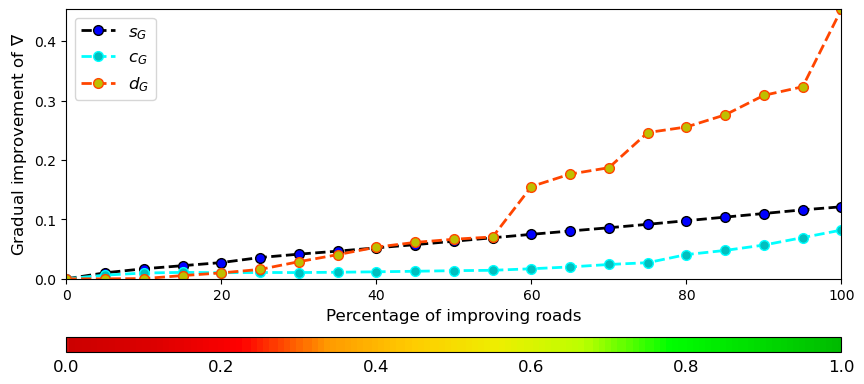

In [36]:
#FROM 2 TO 3
strength = [57.48899051490509, 58.50101626016253, 59.17852303523026, 59.697662601625865, 60.22167174796733, 61.0727896341462, 61.63808434959335, 62.14155657181559, 62.699441056910466, 63.23657689701887, 63.810340447154395, 64.39363143631432, 64.97268800813005, 65.53565379403791, 66.08083502710026, 66.6577743902439, 67.26858909214093, 67.86987635501356, 68.47857384823848, 69.0940464092141, 69.60683434959354]
edge_clustering = [5.2631578947368425, 5.2631578947368425, 7.017543859649122, 7.017543859649122, 7.017543859649122, 12.280701754385966, 17.54385964912281, 22.80701754385965, 29.82456140350877, 42.10526315789474, 50.87719298245614, 50.87719298245614, 59.64912280701754, 63.1578947368421, 63.1578947368421, 66.66666666666667, 66.66666666666667, 66.66666666666667, 70.17543859649123, 70.17543859649123, 70.17543859649123, 71.9298245614035]
# diameter = [30.00554631170272, 30.00554631170272, 30.061009428729896, 30.72656683305602, 31.281198003327788, 32.11314475873544, 33.777038269550744, 35.108153078202996, 36.605657237936775, 37.437603993344425, 38.10316139767055, 38.60232945091514, 49.14032168607876, 51.80255130338325, 52.85635052689961, 60.06655574043261, 61.064891846921796, 63.56073211314476, 67.60953965612867, 69.43982251802552, 86.18968386023295]
# diameter = [58.285509325681495, 58.32137733142038, 58.42898134863702, 58.955045432807275, 59.58871353419417, 60.22238163558106, 60.856049736967954, 61.48971783835485, 62.12338593974175, 62.75705404112865, 63.39072214251554, 64.02439024390245, 64.65805834528933, 65.29172644667624, 65.92539454806314, 66.55906264945003, 67.19273075083692, 67.82639885222382, 68.4600669536107, 69.09373505499761, 69.76327116212339]
diameter = [22.691059309530832, 22.691059309530832, 22.7304022818924, 23.232025179502312, 23.684469361660273, 24.2746139470837, 25.572932035015246, 26.753221205862104, 28.022032064522474, 28.818727254844102, 29.34985738172519, 29.733451362250417, 38.2216976492574, 40.31671092751058, 41.38880692436314, 47.30008852168781, 48.244319858365294, 50.28031867807613, 53.565456870266544, 55.011311104553954, 68.04367069932134]
closeness = [0.45047140896203053, 0.4566582618370194, 0.4601858580564587, 0.46129308279353193, 0.46073211727387636, 0.46108695935705085, 0.46101091886860474, 0.4615068152933313, 0.4622646764683489, 0.46315438184758045, 0.4641620640991358, 0.464786320328804, 0.46737950545218954, 0.47045642741914395, 0.4745732494250549, 0.47760468324468464, 0.49122104726302246, 0.49824468720287823, 0.5072684672377592, 0.5198337616623067, 0.5324552515061375]
# closeness = [41.51450533162684, 42.13318987108123, 42.48578953229026, 42.61209227202198, 42.643257076077745, 42.673771152952924, 42.72264981487195, 42.79749863682726, 42.8631612314369, 42.991496645234896, 43.11484816631971, 43.26178283870101, 43.47970267993209, 43.78880774860035, 44.174585155087364, 44.564600265450046, 45.15096749849634, 45.75094134869607, 46.48917491800907, 47.60510915117394, 49.66736586675631]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closeness[i]*100, diameter[i]])
vec_aux = np.array(vec_aux)/100
# vec_aux = vec_aux / np.linalg.norm(vec_aux, axis=0)
vec_aux = vec_aux - vec_aux[0]
x1 = np.linspace(0, 100, 21)

# Define the colormap
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
markers = ["," , "o" , "^" , "<"]
colors = ['#000000','#00FFFF', '#FF4500','#00FF00']
colors_edge = ['b','c', 'y', 'k']
labels = ['$s_{G}$ ','$c_{G}$','$d_{G}$']
# differences = [diff_1, diff_2, diff_3, diff_4]
for i in range(3):
    plt.plot(x1, vec_aux[:, i],
                color=colors[i],
                markeredgecolor=colors[i],
                lw=2,
                ls='--',
                markerfacecolor=colors_edge[i],
                marker='o',
                #edgecolor=colors_edge[i],
                label=labels[i],
                markersize=7)
# for i in range(4):
#     ax.plot(x1, vec_aux[:, i], color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label=["Strength", "Closeness", "Diameter", "Edge Clustering"][i], markersize=7)

# Set the x and y limits
ax.set_xlim([min(x1), max(x1)])
# ax.set_ylim([min(edge_clustering), max(edge_clustering)])
ax.set_ylim([min(vec_aux.flatten()), max(vec_aux.flatten())])

# Add a horizontal colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities))), ax=ax, orientation='horizontal', aspect=50)
cbar.ax.tick_params(which='both', length=0, pad=5, labelcolor='black', labelsize=12)

# Set the x and y labels
ax.set_xlabel("Percentage of improving roads", fontsize=12)
ax.set_ylabel(r'Gradual improvement of $  \nabla$', fontsize=12)

# Set the legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.savefig('./Images/second_scenario_2_from_2_to_3.png', dpi=800)
plt.show()

In [37]:
bca= {edge: centrality for edge, centrality in nx.edge_betweenness_centrality(G).items() if G.edges[edge]['weight'] == 2}

edge_betweenness = {}
s_bca = max(list(bca.values()))
for i in list(bca.keys()):
    edge_betweenness[i] = (bca[i]/s_bca)

# Sort the edges by their betweenness centrality in descending order
sorted_edges = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)

# Divide the edges into sets of approximately equal size
num_edges = len(sorted_edges)
num_sets = 20
set_size = num_edges // num_sets
edge_sets = [sorted_edges[i:i+set_size] for i in range(0, num_edges, set_size)]

# Compute the average betweenness centrality of each set
# set_centralities = [sum(edge_betweenness[edge] for edge in edge_set) for edge_set in edge_sets]
set_centralities = [sum(edge_betweenness[edge] for edge in edge_set) / len(edge_set) for edge_set in edge_sets]
maxcentrialities = max(set_centralities)
mincentralities = min(set_centralities)
set_centralities = [(edge_set-mincentralities)/(maxcentrialities-mincentralities) for edge_set in set_centralities ]

# Create a colormap for the edge colors
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Draw the graph with the edges colored according to their betweenness centrality

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\4099133541.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


1.0 0.0


C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\3178716555.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.7)


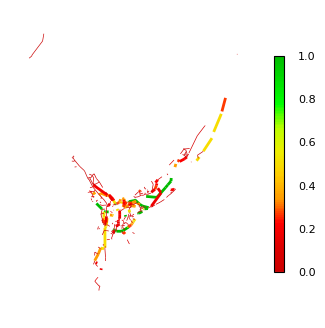

In [38]:
# print(len(set_centralities))
# for i in set_centralities:
#     s1 = s1 + len(i)
# print(s1)
fig, ax = plt.subplots(figsize=(4, 4))
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0)
print(max(set_centralities), min(set_centralities))
for i, edge_set in enumerate(edge_sets):
    # Draw the edges in the first set with colors based on their betweenness centrality
    # print(i, len(edge_set))
    # print(len([edge_color_map((edge_betweenness[edge] - min(edge_betweenness.values())) / (max(edge_betweenness.values()) - min(edge_betweenness.values()))) for edge in edge_set]))
    edge_color_v = [set_centralities[i] for j in range(len(edge_set))]
    # print(len(edge_color_v)) 
    # print(set_centralities[i])
    nx.draw_networkx_edges(G, pos, edgelist=edge_set, edge_color=edge_color_v, width=[2 if set_centralities[i] >= sum(set_centralities)/len(set_centralities) else 0.5 for j in range(len(edge_set))], edge_cmap=edge_color_map, edge_vmin=min(set_centralities), edge_vmax=max(set_centralities))
#np.full(np.arange(len(edge_set)), set_centralities[i])

# Add a colorbar for the edge colors
sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)))
cbar = plt.colorbar(sm, shrink=0.7)
cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=8)
# sm = cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities)), )
# sm.set_array([])
# cbar = plt.colorbar(sm, shrink=0.5)
# cbar.ax.tick_params( which='both', length=0, pad=10, labelcolor='black', labelsize=12)
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.ax.yaxis.set_label_position('left')
# cbar.ax.set_ylabel('Betweenness Centrality', rotation=270, fontsize=14, labelpad=20)
# cbar.ax.yaxis.set_tick_params(width=0)
# Show the plot
plt.axis('off')
plt.savefig(f"Betweenness_grenoble_from_3_to_4.png", dpi=800, bbox_inches='tight')
plt.show()

C:\Users\camperom\AppData\Local\Temp\ipykernel_18632\2507316703.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))


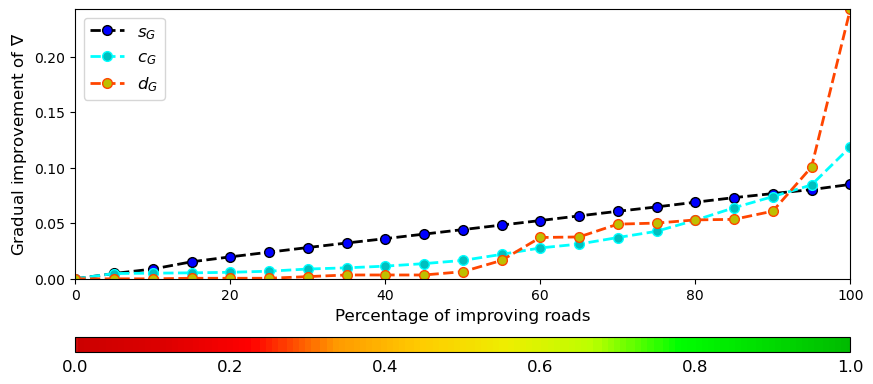

In [39]:

#FROM 3 TO 4
strength = [57.48899051490509, 57.96747967479667, 58.36763211382106, 59.018673780487724, 59.46434620596198, 59.88567073170725, 60.302760840108334, 60.70926490514899, 61.10412432249315, 61.51168699186983, 61.91713245257445, 62.325753726287196, 62.73268123306227, 63.15019478319776, 63.56516768292676, 63.95833333333327, 64.381139905149, 64.7939955962059, 65.15815548780482, 65.51956300813005, 65.98217310298101]
# diameter = [3.2723239046034385, 3.2723239046034385, 3.2723239046034385, 3.3277870216306153, 3.3277870216306153, 3.3277870216306153, 3.494176372712146, 3.6605657237936775, 3.6605657237936775, 3.6605657237936775, 3.9933444259567388, 5.0471436494731, 7.376594564614532, 7.432057681641709, 8.596783139212425, 8.707709373266779, 8.985024958402663, 9.04048807542984, 9.872434830837493, 14.309484193011649, 30.00554631170272]
# diameter = [58.285509325681495, 58.48876135820181, 58.94308943089431, 59.3974175035868, 59.85174557627929, 60.30607364897178, 60.76040172166427, 61.21472979435677, 61.66905786704926, 62.12338593974175, 62.577714012434235, 63.03204208512674, 63.48637015781923, 63.940698230511714, 64.3950263032042, 64.8493543758967, 65.3036824485892, 65.75801052128169, 66.21233859397418, 66.66666666666666, 67.25251076040172]
diameter = [2.862201239303629, 2.862201239303629, 2.862201239303629, 2.911379954755582, 2.911379954755582, 2.911379954755582, 3.058916101111439, 3.206452247467296, 3.206452247467296, 3.206452247467296, 3.5015245401790107, 4.51460607848923, 6.58011212747123, 6.629290842923183, 7.780072784498869, 7.878430215402774, 8.163666765024098, 8.21284548047605, 8.950526212255335, 12.924166420773089, 27.117143700206555]
edge_clustering = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 5.2631578947368425, 5.2631578947368425]
closeness = [0.45047140896203053, 0.4552394356499449, 0.45554981825533725, 0.4558294670770248, 0.4563257807347276, 0.4573061250884565, 0.4592749107781979, 0.4603347209500531, 0.4618710843596121, 0.4641347323029225, 0.467025911811771, 0.4724438725936491, 0.478256992545075, 0.4817457528522614, 0.48761268209680714, 0.49322142876074015, 0.5031930351561552, 0.5144022758031302, 0.5244648897872569, 0.5349654010152454, 0.5691570650274939]
# closeness = [41.51450533162684, 41.982674775959126, 42.003215395945894, 42.026581029549995, 42.06345231431137, 42.126944429093044, 42.20610804440714, 42.30125858068398, 42.42082872295421, 42.593985324296725, 42.80766125170078, 43.110326775943626, 43.49384777677257, 43.805701642368376, 44.2560366159982, 44.744267483930834, 45.3722501769223, 46.04908670112661, 46.94180557470121, 48.009895025318876, 50.85303463904481]
vec_aux = []
for i in range(len(strength)):
    vec_aux.append([strength[i], closeness[i]*100, diameter[i]])
vec_aux = np.array(vec_aux)/100
# vec_aux = vec_aux / 100 
# vec_aux = vec_aux / np.linalg.norm(vec_aux, axis=0)
vec_aux = vec_aux - vec_aux[0]
x1 = np.linspace(0, 100, 21)

# Define the colormap
edge_color_map = ListedColormap(cm.get_cmap('nipy_spectral_r', 256)(np.linspace(0.05, 0.50, 256)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
markers = ["," , "o" , "^" , "<"]
colors = ['#000000','#00FFFF', '#FF4500','#00FF00']
colors_edge = ['b','c', 'y', 'k']
labels = ['$s_{G}$ ','$c_{G}$','$d_{G}$','$ \\varepsilon_{G}$']
# differences = [diff_1, diff_2, diff_3, diff_4]
for i in range(3):
    plt.plot(x1, vec_aux[:, i],
                color=colors[i],
                markeredgecolor=colors[i],
                lw=2,
                ls='--',
                markerfacecolor=colors_edge[i],
                marker='o',
                #edgecolor=colors_edge[i],
                label=labels[i],
                markersize=7)
# for i in range(4):
#     ax.plot(x1, vec_aux[:, i], color='#FF1493', markeredgecolor="#009ACD", lw=2, ls='--', markerfacecolor="#00C957", marker='s', label=["Strength", "Closeness", "Diameter", "Edge Clustering"][i], markersize=7)

# Set the x and y limits
ax.set_xlim([min(x1), max(x1)])
# ax.set_ylim([min(edge_clustering), max(edge_clustering)])
ax.set_ylim([min(vec_aux.flatten()), max(vec_aux.flatten())])

# Add a horizontal colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=edge_color_map, norm=plt.Normalize(vmin=min(set_centralities), vmax=max(set_centralities))), ax=ax, orientation='horizontal', aspect=50)
cbar.ax.tick_params(which='both', length=0, pad=5, labelcolor='black', labelsize=12)

# Set the x and y labels
ax.set_xlabel("Percentage of improving roads", fontsize=12)
ax.set_ylabel(r'Gradual improvement of $\nabla$', fontsize=12)

# Set the legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.savefig('./Images/second_scenario_2_from_3_to_4.png', dpi=800)
plt.show()

In [40]:
def compute_norms(values):
    # Convert the list of vectors to a numpy array
    values_array = np.array(values)

    # Compute the difference between each vector and the first vector
    diff = values_array - values_array[0]

    # Compute the norm of each row in the difference array
    norms = np.linalg.norm(diff, axis=1)

    return norms

In [41]:
strength =[0, 60.7497035907859-57.48899051490509, 69.60683434959354-57.48899051490509, 65.98217310298101-57.48899051490509]
# diameter =[0, 100.0-86.18968386023295, 86.18968386023295-30.00554631170272, 30.00554631170272-3.2723239046034385]
diameter = [0, 68.36825022130422-58.975115569981305,68.04367069932134-22.691059309530832,27.117143700206555-2.862201239303629]
# edge_clustering = [0, 100.0-71.9298245614035, 71.9298245614035-5.2631578947368425, 5.2631578947368425-0.0]
closeness = [0, 0.4637822943118473-0.45047140896203053, 0.5324552515061375-0.45047140896203053, 0.569157065027489-0.45047140896203053]
# diameter = [58.285509325681495, 61.54949784791965, 69.76327116212339, 67.25251076040172]
vec_aux = []
for i in range(len(strength)):
    print([strength[i]/100, closeness[i], diameter[i]/100], i)
    vec_aux.append(np.linalg.norm(np.array([strength[i]/100, closeness[i], diameter[i]/100])))
print(vec_aux)

[0.0, 0, 0.0] 0
[0.032607130758808084, 0.013310885349816781, 0.09393134651322917] 1
[0.1211784383468845, 0.08198384254410696, 0.4535261138979051] 2
[0.08493182588075918, 0.11868565606545844, 0.24254942460902926] 3
[0.0, 0.10031701003771147, 0.4765411843123553, 0.2830722935599651]


In [42]:
strength = [57.48899051490509, 57.66048441734412, 57.79386856368561, 57.92936991869916, 58.15908705962059, 58.36974932249322, 58.52112974254742, 58.66615853658536, 58.81436314363143, 58.96362635501356, 59.11225440379403, 59.279513888888886, 59.42284891598916, 59.58375677506775, 59.74889905149052, 59.90768970189703, 60.08341802168022, 60.24856029810298, 60.41730182926829, 60.578209688346895, 60.7497035907859]
diameter = [86.18968386023295, 86.18968386023295, 86.46699944536883, 86.63338879645036, 87.24348308374931, 87.29894620077648, 87.35440931780366, 88.01996672212978, 88.18635607321131, 88.4636716583472, 88.6855241264559, 89.07376594564614, 89.9057127010538, 90.07210205213532, 90.12756516916251, 92.90072102052135, 95.00831946755409, 95.72933998890738, 96.3948973932335, 96.8940654464781, 100.0]
edge_clustering = [71.9298245614035, 71.9298245614035, 85.96491228070175, 89.47368421052632, 89.47368421052632, 92.98245614035088, 92.98245614035088, 92.98245614035088, 92.98245614035088, 96.49122807017544, 96.49122807017544, 96.49122807017544, 96.49122807017544, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
closeness = [41.51450533162684, 41.55588709114724, 41.55849900803125, 41.56509710001414, 41.573490818861835, 41.580426941028, 41.5956201261148, 41.61345770277875, 41.63408961815237, 41.659631616474265, 41.69613239755049, 41.73775352547659, 41.793105772271524, 41.8594151295603, 41.93604926003764, 42.023553119682035, 42.1113811510486, 42.23465444396502, 42.39747889230064, 42.60354948594502, 42.97032036943511]
strength = np.array(strength)/100
diameter = np.array(diameter)/100
edge_clustering = np.array(edge_clustering)/100
closeness = np.array(closeness)/100
strength_var = np.var(strength)
closeness_var = np.var(closeness)
diameter_var = np.var(diameter)
edge_clustering_var = np.var(edge_clustering)

# Print the results
print(f"Variance of strength: {strength_var}")
print(f"Variance of closeness: {closeness_var}")
print(f"Variance of diameter: {diameter_var}")
print(f"Variance of edge clustering: {edge_clustering_var}")

Variance of strength: 9.595562271373084e-05
Variance of closeness: 1.4893460332021924e-05
Variance of diameter: 0.0016164348900336433
Variance of edge clustering: 0.006511857431021368


In [43]:
strength = [57.48899051490509, 58.50101626016253, 59.17852303523026, 59.697662601625865, 60.22167174796733, 61.0727896341462, 61.63808434959335, 62.14155657181559, 62.699441056910466, 63.23657689701887, 63.810340447154395, 64.39363143631432, 64.97268800813005, 65.53565379403791, 66.08083502710026, 66.6577743902439, 67.26858909214093, 67.86987635501356, 68.47857384823848, 69.0940464092141, 69.60683434959354]
edge_clustering = [5.2631578947368425, 5.2631578947368425, 7.017543859649122, 7.017543859649122, 7.017543859649122, 12.280701754385966, 17.54385964912281, 22.80701754385965, 29.82456140350877, 42.10526315789474, 50.87719298245614, 50.87719298245614, 59.64912280701754, 63.1578947368421, 63.1578947368421, 66.66666666666667, 66.66666666666667, 66.66666666666667, 70.17543859649123, 70.17543859649123, 70.17543859649123, 71.9298245614035]
diameter = [30.00554631170272, 30.00554631170272, 30.061009428729896, 30.72656683305602, 31.281198003327788, 32.11314475873544, 33.777038269550744, 35.108153078202996, 36.605657237936775, 37.437603993344425, 38.10316139767055, 38.60232945091514, 49.14032168607876, 51.80255130338325, 52.85635052689961, 60.06655574043261, 61.064891846921796, 63.56073211314476, 67.60953965612867, 69.43982251802552, 86.18968386023295]
closeness = [41.51450533162684, 42.13318987108123, 42.48578953229026, 42.61209227202198, 42.643257076077745, 42.673771152952924, 42.72264981487195, 42.79749863682726, 42.8631612314369, 42.991496645234896, 43.11484816631971, 43.26178283870101, 43.47970267993209, 43.78880774860035, 44.174585155087364, 44.564600265450046, 45.15096749849634, 45.75094134869607, 46.48917491800907, 47.60510915117394, 49.66736586675631]# strength = np.array(strength)/100
strength = np.array(strength)/100
diameter = np.array(diameter)/100
edge_clustering = np.array(edge_clustering)/100
closeness = np.array(closeness)/100
strength_var = np.var(strength)
closeness_var = np.var(closeness)
diameter_var = np.var(diameter)
edge_clustering_var = np.var(edge_clustering)

# Print the results
print(f"Variance of strength: {strength_var}")
print(f"Variance of closeness: {closeness_var}")
print(f"Variance of diameter: {diameter_var}")
print(f"Variance of edge clustering: {edge_clustering_var}")

Variance of strength: 0.0012648992239159612
Variance of closeness: 0.00038311745175737693
Variance of diameter: 0.025764224052711625
Variance of edge clustering: 0.06743333613139711


In [44]:
strength = [57.48899051490509, 57.96747967479667, 58.36763211382106, 59.018673780487724, 59.46434620596198, 59.88567073170725, 60.302760840108334, 60.70926490514899, 61.10412432249315, 61.51168699186983, 61.91713245257445, 62.325753726287196, 62.73268123306227, 63.15019478319776, 63.56516768292676, 63.95833333333327, 64.381139905149, 64.7939955962059, 65.15815548780482, 65.51956300813005, 65.98217310298101]
diameter = [3.2723239046034385, 3.2723239046034385, 3.2723239046034385, 3.3277870216306153, 3.3277870216306153, 3.3277870216306153, 3.494176372712146, 3.6605657237936775, 3.6605657237936775, 3.6605657237936775, 3.9933444259567388, 5.0471436494731, 7.376594564614532, 7.432057681641709, 8.596783139212425, 8.707709373266779, 8.985024958402663, 9.04048807542984, 9.872434830837493, 14.309484193011649, 30.00554631170272]
edge_clustering = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 1.7543859649122806, 5.2631578947368425, 5.2631578947368425]
closeness = [41.51450533162684, 41.982674775959126, 42.003215395945894, 42.026581029549995, 42.06345231431137, 42.126944429093044, 42.20610804440714, 42.30125858068398, 42.42082872295421, 42.593985324296725, 42.80766125170078, 43.110326775943626, 43.49384777677257, 43.805701642368376, 44.2560366159982, 44.744267483930834, 45.3722501769223, 46.04908670112661, 46.94180557470121, 48.009895025318876, 50.85303463904481]
strength = np.array(strength)/100
diameter = np.array(diameter)/100
edge_clustering = np.array(edge_clustering)/100
closeness = np.array(closeness)/100
strength_var = np.var(strength)
closeness_var = np.var(closeness)
diameter_var = np.var(diameter)
edge_clustering_var = np.var(edge_clustering)

# Print the results
print(f"Variance of strength: {strength_var}")
print(f"Variance of closeness: {closeness_var}")
print(f"Variance of diameter: {diameter_var}")
print(f"Variance of edge clustering: {edge_clustering_var}")

Variance of strength: 0.0006418443921239822
Variance of closeness: 0.0005540191875616019
Variance of diameter: 0.0035502636497386684
Variance of edge clustering: 0.00020413146829666599


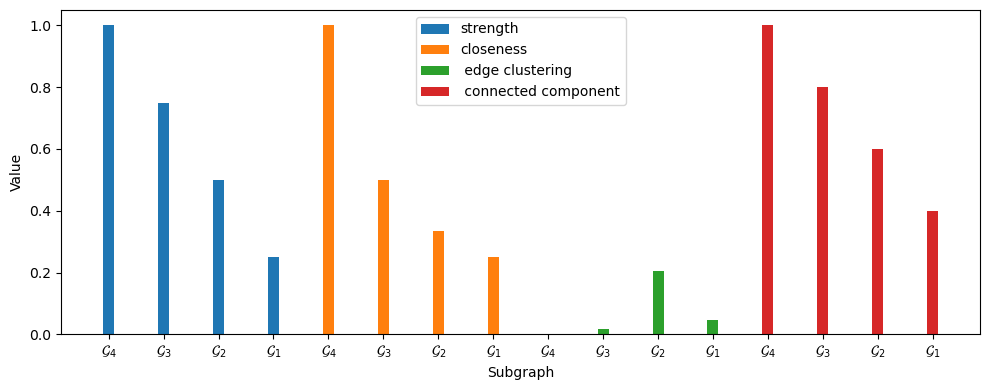

In [45]:
# strength = np.array([78.59882005899706, 64.01889009399854, 59.82132847533637, 57.48899051490509])/100
# closeness = np.array([21.475943949707823, 10.507245268603134, 33.68549342877903, 45.80457612194374])/100
# edge_clustering = np.array([0, 6.432748538011695, 65.78947368421052, 100.0])/100
# diameter = np.array([3.2723239046034385, 30.00554631170272, 86.18968386023295, 100.0])/100
strength = np.array([100.0, 75.0, 50.0, 25.0])/100
closeness = np.array([100.0, 50.0, 33.333333333333314, 25.0])/100
edge_clustering = np.array([0, 1.7543859649122804, 20.467836257309948, 4.678362573099415])/100
diameter = np.array([100.0, 79.9301919720768, 59.9388379204893, 40.0])/100
# diameter = np.array([100.0, 75.0, 50.0, 25.0])/100
# diameter = np.array([100.0, 100.0, 100.0, 100.0])/100
# Define the x-axis labels
# Define the x-axis labels in LaTeX format
# labels = ['$\\mathcal{G}_{4}$', '$ \\uplus_{i=3}^{4} \\mathcal{G}_{i}$', '$\\uplus_{i=2}^{4} \\mathcal{G}_{i}$', '$\\uplus_{i=1}^{4} \\mathcal{G}_{i}$']
labels = ['$\\mathcal{G}_{4}$', '$ \\mathcal{G}_{3}$', '$ \\mathcal{G}_{2}$', '$ \\mathcal{G}_{1}$']

# Define the x-axis positions for each group of bars
x = np.arange(len(labels)*4)

# Define the width of each bar
width = 0.2

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))
# labels = ['$s_{G}$ ','$c_{G}$','$d_{G}$','$ \\varepsilon_{G}$']
# Plot the bars for each group
# ax.bar(x[0:4], strength, width, label='$s_{G}$')
# ax.bar(x[4:8], closeness, width, label='$c_{G}$')
# ax.bar(x[8:12], edge_clustering, width, label='$ \\varepsilon_{G}$')
# ax.bar(x[12:16], diameter, width, label='$d_{G}$')


ax.bar(x[0:4], strength, width, label='strength')
ax.bar(x[4:8], closeness, width, label='closeness')
ax.bar(x[8:12], edge_clustering, width, label=' edge clustering')
ax.bar(x[12:16], diameter, width, label=' connected component')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(labels*4)

# Set the x-axis label in LaTeX format
ax.set_xlabel('Subgraph')

# Set the y-axis label
ax.set_ylabel('Value')

# Add a legend
ax.legend()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Automatically adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig('./Images/statistical_results.png', dpi=800)
plt.show()

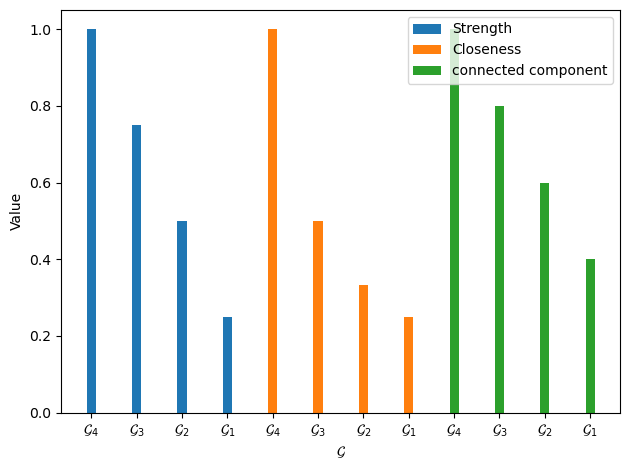

In [46]:
strength = np.array([100.0, 75.0, 50.0, 25.0])/100
closeness = np.array([100, 50, 33.33333333333293, 25])/100
diameter = np.array([100.0, 79.9301919720768, 59.9388379204893, 40.0])/100
# Define the x-axis labels in LaTeX format
labels = ['$\\mathcal{G}_{4}$', '$\\mathcal{G}_{3}$', '$\\mathcal{G}_{2}$', '$\\mathcal{G}_{1}$']

# Define the x-axis positions for each group of bars
x = np.arange(len(labels)*3)

# Define the width of each bar
width = 0.2

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the bars for each group
ax.bar(x[0:4], strength, width, label='Strength')
ax.bar(x[4:8], closeness, width, label='Closeness')
ax.bar(x[8:12], diameter, width, label='connected component')
# ax.bar(x[12:16], diameter, width, label='Diameter')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(labels*3)

# Set the x-axis label in LaTeX format
ax.set_xlabel('$\\mathcal{G}$')

# Set the y-axis label
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Adjust the spacing between the plot and the figure edges
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Automatically adjust the spacing between subplots
plt.tight_layout()
plt.savefig('./Images/statistical_Data.png', dpi=800)
# Show the plot
plt.show()

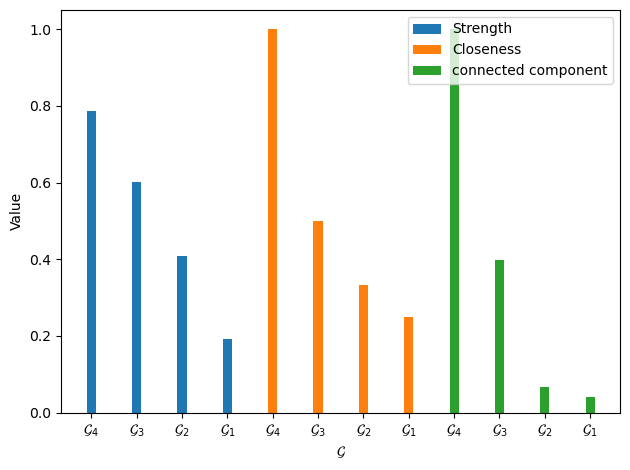

In [47]:
strength = np.array([78.59882005899706, 60.124400479616305, 40.80054177359562, 19.212824351297414])/100
closeness = np.array([100, 50, 33.33333333333293, 25])/100
# closeness = np.array([85.90377579883126, 13.192238356411425, 9.863371327637783, 10.785424548672731])/100
diameter = np.array([100.0, 39.705244906805376, 6.537691794529686, 4.0431266846361185])/100
# Define the x-axis labels in LaTeX format
labels = ['$\\mathcal{G}_{4}$', '$\\mathcal{G}_{3}$', '$\\mathcal{G}_{2}$', '$\\mathcal{G}_{1}$']

# Define the x-axis positions for each group of bars
x = np.arange(len(labels)*3)

# Define the width of each bar
width = 0.2

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the bars for each group
ax.bar(x[0:4], strength, width, label='Strength')
ax.bar(x[4:8], closeness, width, label='Closeness')
ax.bar(x[8:12], diameter, width, label='connected component')
# ax.bar(x[12:16], diameter, width, label='Diameter')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(labels*3)

# Set the x-axis label in LaTeX format
ax.set_xlabel('$\\mathcal{G}$')

# Set the y-axis label
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Adjust the spacing between the plot and the figure edges
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Automatically adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
0.45047140896203053, 0.4637822943118473, 0.5324552515061375, 0.569157065027489

[0.4552394356499449, 0.45554981825533725, 0.4558294670770248, 0.4563257807347276, 0.4573061250884565, 0.4592749107781979, 0.4603347209500531, 0.4618710843596121, 0.4641347323029225, 0.467025911811771, 0.4724438725936491, 0.478256992545075, 0.4817457528522614, 0.48761268209680714, 0.49322142876074015, 0.5031930351561552, 0.5144022758031302, 0.5244648897872569, 0.5349654010152454, 0.5691570650274939]
{1: [0.45088499694200085, 0.45082000186041504, 0.45088008875346847, 0.4509673018327711, 0.4510426042226104, 0.45115691742830144, 0.45123174907732844, 0.45098395559492793, 0.45117417982401503, 0.45129236358070024, 0.45172991227738807, 0.45185158024422, 0.45208470134695816, 0.45272744220003003, 0.4535460564809435, 0.45441343932963635, 0.4556244705976293, 0.4572263222453883, 0.45958491937010276, 0.463782294311847], 2: [0.4566582618370194, 0.4601858580564587, 0.46129308279353193, 0.46073211727387636, 0.46108695935705085, 0.46101091886860474, 0.4615068152933313, 0.4622646764683489, 0.46315438184758045, 0.4641620640991358, 0.464786320328804, 0.46737950545218954, 0.47045642741914395, 0.4745732494250549, 0.47760468324468464, 0.49122104726302246, 0.49824468720287823, 0.5072684672377592, 0.5198337616623067, 0.5324552515061375], 3: [0.4552394356499449, 0.45554981825533725, 0.4558294670770248, 0.4563257807347276, 0.4573061250884565, 0.4592749107781979, 0.4603347209500531, 0.4618710843596121, 0.4641347323029225, 0.467025911811771, 0.4724438725936491, 0.478256992545075, 0.4817457528522614, 0.48761268209680714, 0.49322142876074015, 0.5031930351561552, 0.5144022758031302, 0.5244648897872569, 0.5349654010152454, 0.5691570650274939]}


{1: [0.45088499694200085,
  0.45082000186041504,
  0.45088008875346847,
  0.4509673018327711,
  0.4510426042226104,
  0.45115691742830144,
  0.45123174907732844,
  0.45098395559492793,
  0.45117417982401503,
  0.45129236358070024,
  0.45172991227738807,
  0.45185158024422,
  0.45208470134695816,
  0.45272744220003003,
  0.4535460564809435,
  0.45441343932963635,
  0.4556244705976293,
  0.4572263222453883,
  0.45958491937010276,
  0.463782294311847],
 2: [0.4566582618370194,
  0.4601858580564587,
  0.46129308279353193,
  0.46073211727387636,
  0.46108695935705085,
  0.46101091886860474,
  0.4615068152933313,
  0.4622646764683489,
  0.46315438184758045,
  0.4641620640991358,
  0.464786320328804,
  0.46737950545218954,
  0.47045642741914395,
  0.4745732494250549,
  0.47760468324468464,
  0.49122104726302246,
  0.49824468720287823,
  0.5072684672377592,
  0.5198337616623067,
  0.5324552515061375],
 3: [0.4552394356499449,
  0.45554981825533725,
  0.4558294670770248,
  0.4563257807347276,
 

In [49]:
print(sum([78.59882005899706, 60.124400479616305, 40.80054177359562, 19.212824351297414])/4)
print(sum([100, 50, 33.33333333333293, 25])/4)


49.6841466658766
52.08333333333323


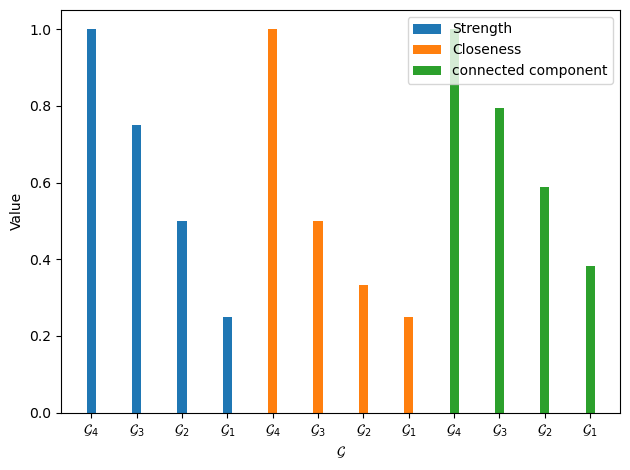

In [50]:
strength = np.array([100.0, 75.0, 50.0, 25.0])/100
closeness = np.array([1.0, 0.5, 0.3333333333333357, 0.25])
# closeness = np.array([85.90377579883126, 13.192238356411425, 9.863371327637783, 10.785424548672731])/100
diameter = np.array([100.0, 79.43346119799351, 58.86692239598702, 38.30038359398053])/100
# Define the x-axis labels in LaTeX format
labels = ['$\\mathcal{G}_{4}$', '$\\mathcal{G}_{3}$', '$\\mathcal{G}_{2}$', '$\\mathcal{G}_{1}$']

# Define the x-axis positions for each group of bars
x = np.arange(len(labels)*3)

# Define the width of each bar
width = 0.2

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the bars for each group
ax.bar(x[0:4], strength, width, label='Strength')
ax.bar(x[4:8], closeness, width, label='Closeness')
ax.bar(x[8:12], diameter, width, label='connected component')
# ax.bar(x[12:16], diameter, width, label='Diameter')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(labels*3)

# Set the x-axis label in LaTeX format
ax.set_xlabel('$\\mathcal{G}$')

# Set the y-axis label
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Adjust the spacing between the plot and the figure edges
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Automatically adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()